## SHAP profiles - explanations of individual predictions
 
TreeExplainer source: https://github.com/slundberg/shap

TreeExplainer assigns credit to each feature for each prediction.

**Input**:
* All paralog pair feature values
* Predictions for all paralog pairs
* Random Forest Classifier (pickle)

**Output:**
* SHAP values associated with all features in all pairs
* Table S8: SHAP values and prediction for all features/pairs

In [6]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import graphing_params as gp
%load_ext autoreload
%autoreload 1
%aimport graphing_params

import pickle
import os, sys
stdout = sys.stdout
import shap
sys.stdout = stdout

# load JS visualization code to notebook
shap.initjs()

mpl.rcParams.update({'ytick.labelsize':9})

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_feature_list = get_local_data_path([],'feature_list.txt')
file_feature_names = get_local_data_path([],'feature_names.txt')
file_RF_model = get_local_data_path(['results'], 'RF_model.pickle')
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_all_predictions = get_local_data_path(['results'], 'all_predictions.csv')

# Output
file_all_shap_values = get_local_data_path(['results'], 'all_shap_values.csv')
file_table_s9 = get_local_data_path(['supplemental_files'], 'Table_S9.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data: all feature annotated paralog pairs + their predictions

In [2]:
all_paralog_annotations = pd.read_csv(file_annot_pairs)
print('Num annotated paralog pairs:', all_paralog_annotations.shape[0])
all_paralog_annotations[:1]

Num annotated paralog pairs: 36648


,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,has_cerevisiae_ortholog_ip,has_pombe_ortholog,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc
0,A1BG_OSCAR,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,1,126014,False,0.127273,0.22028,...,False,False,False,False,False,False,3,210.95,0.0,False


In [7]:
features = pd.read_csv(file_feature_list).feature.values.tolist()
print('N features', len(features))

N features 22


In [8]:
feature_labels = pd.read_csv(file_feature_names, sep='\t')
# Just adding a space so the label doesn't get cut off when saving figure
feature_labels.loc[feature_labels.feature=='mean_complex_essentiality', 'simple_name'] = ' Essentiality of Protein Complex(es)'
feature_labels[:1]

,simple_name,feature,category
0,Sequence Identity,min_sequence_identity,Sequence


In [9]:
all_predictions = pd.read_csv(file_all_predictions)
all_predictions[:1]

,prediction_rank,prediction_percentile,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,prediction_score,validated_SL,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL,depmap_hit
0,1,0.1,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,ENSG00000080503,ENSG00000127616,0.430886,True,2.0,0.0,0.0,0.0,4,1,True


### Load RF classifier and generate SHAP values for all paralog pairs

In [10]:
with open(file_RF_model, 'rb') as f:
    RF = pickle.load(f)

In [12]:
explainer = shap.TreeExplainer(RF, feature_perturbation="tree_path_dependent")
all_shap_values_raw = explainer.shap_values(all_paralog_annotations[features])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [13]:
print('Expected value:', explainer.expected_value[1])

Expected value: 0.03476655659512018


In [14]:
all_shap_values = pd.DataFrame(all_shap_values_raw[1], columns=features)
all_shap_values = pd.concat([all_paralog_annotations[['sorted_gene_pair','A1','A2','A1_entrez','A2_entrez']], 
                             all_shap_values], axis=1)
all_shap_values.to_csv(file_all_shap_values, index=0)
all_shap_values[:2]

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,min_sequence_identity,closest,WGD,family_size,cds_length_ratio,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A1BG_OSCAR,A1BG,OSCAR,1,126014,0.003077,-0.002660,-0.000885,0.000395,-0.000166,...,-0.000151,-0.003835,-0.000071,-0.000202,0.000054,-0.004008,-0.000630,0.000119,-0.000204,-0.000005
1,A1BG_TARM1,A1BG,TARM1,1,441864,0.003167,-0.002734,-0.000860,0.000328,0.000196,...,-0.000145,-0.004242,-0.000069,-0.000178,-0.000015,-0.004441,-0.000629,0.003489,-0.000223,0.000042


In [15]:
# Also save as Table S9 (add predictions to this)
table_s9 = pd.merge(all_predictions[['prediction_rank','sorted_gene_pair','A1','A2',
                                     'A1_entrez','A2_entrez','prediction_score']], all_shap_values)
assert(table_s9.shape[0] == all_shap_values.shape[0])
table_s9.to_csv(file_table_s9, index=0)
table_s9[:2]

,prediction_rank,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,prediction_score,min_sequence_identity,closest,WGD,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,1,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,0.430886,0.161258,0.024044,0.007880,...,0.001976,0.054886,0.000172,0.001757,0.001503,0.049722,0.004440,-0.000868,0.002244,0.000671
1,2,EXOC6_EXOC6B,EXOC6,EXOC6B,54536,23233,0.410447,0.161088,0.023801,0.005154,...,0.002148,0.062069,0.000453,0.001687,0.002408,0.012050,0.002372,0.003945,-0.001956,0.000252


### Global top SHAP values

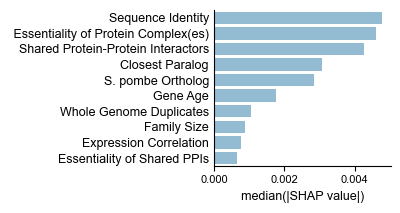

In [18]:
# Top 10 most predictive features (for all paralog pairs)
assert(all_shap_values.iloc[:,5:].shape[1]==22)
med_abs_shap = all_shap_values.iloc[:,5:].abs().median().sort_values(ascending=False).reset_index()
med_abs_shap.columns = ['feature','value']
med_abs_shap = pd.merge(med_abs_shap, feature_labels)
top_features = med_abs_shap.feature.values.tolist()

f, ax = plt.subplots(1, 1, figsize=(4.2,2.2))
sns.barplot(y=med_abs_shap[:10]['simple_name'], x=med_abs_shap[:10]['value'], color=sns.color_palette("Blues")[2])
ax.set_xlabel('median(|SHAP value|)')
_ = ax.set_ylabel(''); ax.tick_params(axis='y', which='both', length=0);
plt.tight_layout()

### Compute z-scores for all feature values

In [24]:
# Calculate zscores for each feature for all pairs
zmin=-2; zmax=2
def calculate_zscores_for_feature(x):
    dtype = all_paralog_annotations[x.name].dtype
    if dtype == 'float64' or dtype=="int64":
        return pd.Series(stats.zscore(np.array(x.values, dtype=np.float64))).clip(lower=zmin, upper=zmax)
    elif dtype == 'bool':
        return x.apply(lambda y: 2 if y==True else -2)
    else:
        print('Unexpected type:', dtype)

all_pairs_zscores = all_paralog_annotations[features].apply(calculate_zscores_for_feature)
all_pairs_zscores = pd.concat([all_paralog_annotations[['sorted_gene_pair']], all_pairs_zscores], axis=1)
assert(all_pairs_zscores.shape[0] == all_paralog_annotations.shape[0])
all_pairs_zscores[:1]

,sorted_gene_pair,min_sequence_identity,closest,WGD,family_size,cds_length_ratio,shared_domains,has_pombe_ortholog,has_essential_pombe_ortholog,has_cerevisiae_ortholog,...,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,shared_ppi_mean_essentiality,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A1BG_OSCAR,-1.108744,-2,-2,-1.010515,-1.24205,0.69377,-2,-2,-2,...,-2,-0.303995,-0.429845,-2,-0.335195,-0.305117,-0.440612,-0.111747,0.004431,-0.141276


#### Merge feature values, feature z-scores, shap values and predictions

In [28]:
assert(all_shap_values.shape[0] == all_pairs_zscores.shape[0])
# Merge feature zscores and shap values
all_shap_and_zscore = pd.merge(
    pd.melt(all_pairs_zscores, id_vars=['sorted_gene_pair']).rename(columns={'value':'zscore'}),
    pd.melt(all_shap_values, id_vars=['sorted_gene_pair']).rename(columns={'value':'shap_value'})
)
# Add feature values - round float64s to 3 decimal places
all_feature_values = all_paralog_annotations[['sorted_gene_pair']+features]
all_feature_values = all_feature_values.apply(lambda x: round(x, 3) if x.infer_objects().dtype == 'float64' else x)
all_shap_and_zscore = pd.merge(
    all_shap_and_zscore, 
    pd.melt(all_feature_values, id_vars=['sorted_gene_pair']).rename(columns={'value':'feature_value'})
)
all_shap_and_zscore = all_shap_and_zscore.rename(columns={'variable':'feature'})
display(all_shap_and_zscore[:1])

# Add prediction
all_shap_and_zscore = pd.merge(all_shap_and_zscore, all_predictions[['sorted_gene_pair','A1','A2','prediction_rank']])
assert(all_shap_and_zscore.shape[0] == all_pairs_zscores.shape[0]*len(features))

# Add feature simple names
all_shap_and_zscore = pd.merge(all_shap_and_zscore, feature_labels.drop(columns=['category']))

# Add global feature ranks (for use on web page)
all_shap_and_zscore = pd.merge(all_shap_and_zscore, 
                    pd.DataFrame(top_features, columns=['feature']).reset_index().rename(columns={'index':'global_feat_rank'}))
all_shap_and_zscore[:1]

,sorted_gene_pair,feature,zscore,shap_value,feature_value
0,A1BG_OSCAR,min_sequence_identity,-1.108744,0.003077,0.127


,sorted_gene_pair,feature,zscore,shap_value,feature_value,A1,A2,prediction_rank,simple_name,global_feat_rank
0,A1BG_OSCAR,min_sequence_identity,-1.108744,0.003077,0.127,A1BG,OSCAR,17806,Sequence Identity,0


In [29]:
print('Min and max SHAP values:', all_shap_and_zscore.shap_value.min(), ',', all_shap_and_zscore.shap_value.max())

Min and max SHAP values: -0.025437170510926435 , 0.16928366946699494


In [30]:
display(all_shap_and_zscore[all_shap_and_zscore.shap_value == all_shap_and_zscore.shap_value.max()])
display(all_shap_and_zscore[all_shap_and_zscore.shap_value == all_shap_and_zscore.shap_value.min()])

,sorted_gene_pair,feature,zscore,shap_value,feature_value,A1,A2,prediction_rank,simple_name,global_feat_rank
30606,STAG1_STAG2,min_sequence_identity,1.552713,0.169284,0.708,STAG1,STAG2,3,Sequence Identity,0


,sorted_gene_pair,feature,zscore,shap_value,feature_value,A1,A2,prediction_rank,simple_name,global_feat_rank
10369,DDB1_SF3B3,min_sequence_identity,-0.682946,-0.025437,0.22,DDB1,SF3B3,1238,Sequence Identity,0


#### For web page

In [192]:
# get_web_data_path = lambda fname: os.path.normpath('../webpage/data/'+ fname)

In [197]:
# # Save one file per pair for web page
# for idx, row in all_predictions.iterrows():
#     df = all_shap_and_zscore[(all_shap_and_zscore.A1==row.A1) & (all_shap_and_zscore.A2==row.A2)]
#     df.to_csv(get_web_data_path(row.A1+'_'+row.A2+'.csv'), index=0)

In [193]:
# # Also save index file with all pairs
# all_predictions[['A1','A2']].to_csv(get_web_data_path('0_all_pairs_index.csv'), index=0)

### SHAP plots for individual paralog pairs

In [31]:
zmin=-2; zmax=2
palette = sns.color_palette("coolwarm", 5)
cmap = mpl.colors.ListedColormap(palette.as_hex())

def draw_colorbar(f, ax, cmap, zmin, zmax, height=0.5, width=0.015, xpadding=0.03, ypadding=0):
    bbox_ax = ax.get_position()
    # colorbar is bounded by [x0, y0, x_width, y_width]
    cbar_ax = f.add_axes([bbox_ax.x1+xpadding, bbox_ax.y0+ypadding, width, (bbox_ax.y1-bbox_ax.y0)*height])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(zmin, zmax))
    cbar = f.colorbar(sm, cax=cbar_ax, ticks=[-1.2, -0.4, 0.4, 1.2])
    cbar.set_label('Feature z-score', rotation=270, labelpad=10)
    cbar.outline.set_visible(False)
    cbar_ax.tick_params(right=False, pad=0)
    for t in cbar_ax.get_yticklabels(): t.set_fontsize(8)
    return cbar_ax

def draw_shap_plot_for_pair(A1, A2, ax, feature_order=[], n=10):
    pair = pd.DataFrame({'A1':A1, 'A2':A2}, index=[0])
    # DF incl. columns: feature, shap_value, zcore
    df = pd.merge(pair, all_shap_and_zscore)
    # Order features
    if len(feature_order)==0:
        df = df[df.index.isin(df.shap_value.abs().nlargest(n=n).index)].sort_values('shap_value', ascending=False)
    else:
        df = df.set_index('feature').loc[feature_order,:].reset_index()
    # Map zscore to a discrete color range
    df['color_idx'] = df.zscore.apply(lambda x: np.round(((x-zmin)/(zmax-zmin)) * (len(palette)-1)).astype(np.int32))
    sns.barplot(x=df.shap_value, y=df.simple_name, ax=ax, palette=np.array(palette)[df.color_idx.values], saturation=1)
    ax.tick_params(axis='y', which='both', length=0); ax.set_ylabel('')
    ax.set_title(A1+'/'+A2, fontsize=9, fontweight='bold', fontstyle="italic")
    ax.set_xlabel('SHAP value')

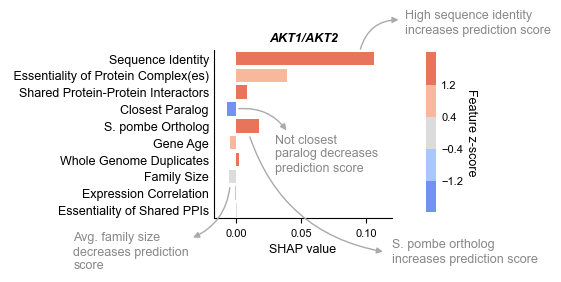

In [32]:
f, ax = plt.subplots(1, 1, figsize=(4.2,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('AKT1', 'AKT2', ax, feature_order=top_features[:10])
ax.set_xlim([-0.017, 0.12])
plt.tight_layout()

# Draw annotations
ax.text(0.13, -1.5, 'High sequence identity\nincreases prediction score', fontsize=9, color='#888')
ax.annotate("", xy=(0.095, -0.4), xycoords='data', xytext=(0.127, -2.3), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.4", color="#aaa"))

ax.text(0.03, 6.7, 'Not closest\nparalog decreases\nprediction score', fontsize=9, color='#888')
ax.annotate("", xy=(0, 3), xycoords='data', xytext=(0.04, 4.4), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.3", color="#aaa"))

ax.text(-0.125, 12.5, 'Avg. family size\ndecreases prediction\nscore', fontsize=9, color='#888')
ax.annotate("", xy=(-0.0045, 7.5), xycoords='data', xytext=(-0.035, 10.7), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=0.3", color="#aaa"))

ax.text(0.12, 12.1, 'S. pombe ortholog\nincreases prediction score', fontsize=9, color='#888')
ax.annotate("", xy=(0.01, 4.5), xycoords='data', xytext=(0.115, 11.5), textcoords='data', 
            arrowprops=dict(arrowstyle="<|-", connectionstyle="arc3,rad=-0.3", color="#aaa"))

cbar = draw_colorbar(f, ax, cmap, zmin, zmax, height=0.95, width=0.025, xpadding=0.08, ypadding=0.025)
f.savefig("../figures/for_paper/akt12_shap_annotated.svg", bbox_inches="tight", dpi=400)

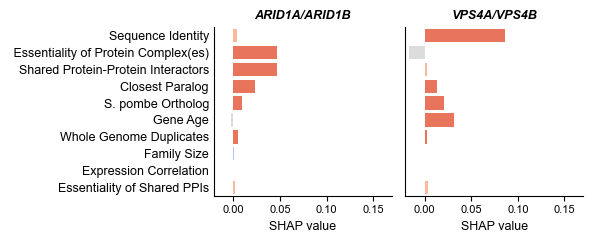

In [33]:
f, ax = plt.subplots(1, 2, figsize=(6,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('ARID1A', 'ARID1B', ax[0], feature_order=top_features[:10])
draw_shap_plot_for_pair('VPS4A', 'VPS4B', ax[1], feature_order=top_features[:10])
ax[0].set_xlim([-0.021, 0.17])
plt.tight_layout()
f.savefig("../figures/for_paper/vps4ab_arid1ab_shap.svg", bbox_inches="tight", dpi=300)

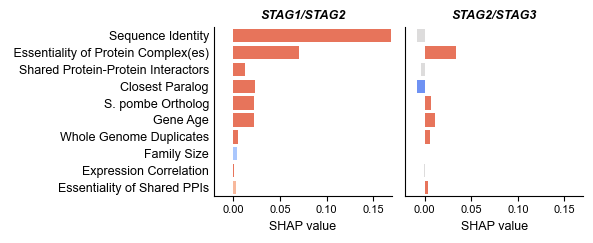

In [34]:
f, ax = plt.subplots(1, 2, figsize=(6,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('STAG1', 'STAG2', ax[0], feature_order=top_features[:10])
draw_shap_plot_for_pair('STAG2', 'STAG3', ax[1], feature_order=top_features[:10])
ax[0].set_xlim([-0.021, 0.17])
plt.tight_layout()
f.savefig("../figures/for_paper/stag123_shap.svg", bbox_inches="tight", dpi=300)

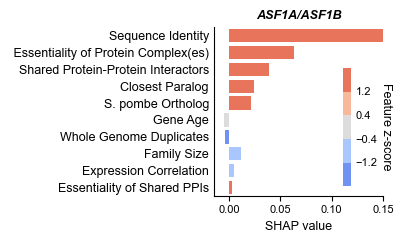

In [37]:
f, ax = plt.subplots(1, 1, figsize=(4,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('ASF1A', 'ASF1B', ax, feature_order=top_features[:10])
plt.tight_layout()
ax.set_xlim([-0.015, 0.15])
cbar = draw_colorbar(f, ax, cmap, zmin, zmax, height=0.7, width=0.02, xpadding=-0.1, ypadding=0.04)
f.savefig("../figures/for_paper/asf1ab_shap.svg", bbox_inches="tight", dpi=300)

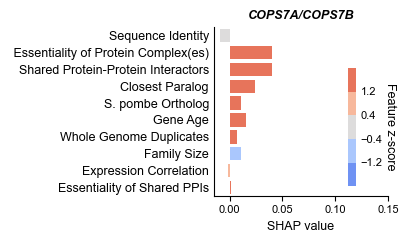

In [41]:
f, ax = plt.subplots(1, 1, figsize=(4.05,2.5), sharex=True, sharey=True)
draw_shap_plot_for_pair('COPS7A', 'COPS7B', ax, feature_order=top_features[:10])
plt.tight_layout()
ax.set_xlim([-0.015, 0.15])
cbar = draw_colorbar(f, ax, cmap, zmin, zmax, height=0.7, width=0.02, xpadding=-0.1, ypadding=0.04)
f.savefig("../figures/for_paper/cops7ab_shap.svg", bbox_inches="tight", dpi=300)

#### Waterfall plot to show prediction rank for COPS7A/COPS7B

In [57]:
# Waterfall plot of all predictions, with some highlighted examples
def draw_waterfall_plot_w_examples(pairs, ax):
    df = all_predictions.assign(example = all_predictions.sorted_gene_pair.isin(pairs))
    color = sns.color_palette("Blues", n_colors=9)[8]
    sns.lineplot(x=df.prediction_rank, y=df.prediction_score, ax=ax, alpha=1, color='#ccc', label="All predictions", zorder=0)
    sns.scatterplot(x=df[df.example].prediction_rank, y=df[df.example].prediction_score, ax=ax, linewidth=0, s=20, alpha=0.8, 
                    color=color, label="Featured pair")
    ax.set_ylabel('Prediction score'); ax.set_xlabel('Prediction rank')

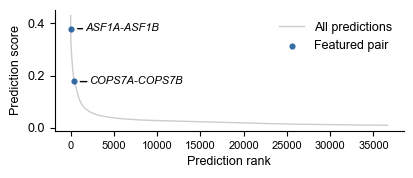

In [58]:
f, ax = plt.subplots(1, 1, figsize=(4.5,1.6))
draw_waterfall_plot_w_examples(['ASF1A_ASF1B','COPS7A_COPS7B'], ax)

# Plot annotations
ax.text(1700, 0.37, 'ASF1A-ASF1B', fontsize=8, fontstyle="italic")
ax.annotate("", xy=(500, 0.38), xycoords='data', xytext=(1700, 0.38), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(2200, 0.17, 'COPS7A-COPS7B', fontsize=8, fontstyle="italic")
ax.annotate("", xy=(800, 0.177), xycoords='data', xytext=(2200, 0.177), textcoords='data', arrowprops=dict(arrowstyle="-"))

f.savefig("../figures/for_paper/waterfall_plot_asf1_cops7.svg", bbox_inches="tight", dpi=300)

### Predictions for all paralog pairs that include *AKT1*

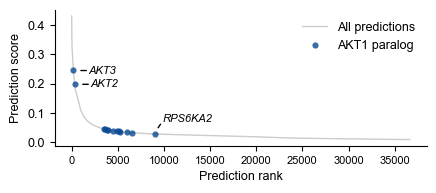

In [51]:
f, ax = plt.subplots(1, 1, figsize=(4.8,1.8))
draw_waterfall_plot_w_examples(all_predictions[all_predictions.A1=='AKT1'].sorted_gene_pair.values.tolist(), ax)
ax.legend(labels=['All predictions', 'AKT1 paralog'])

# Plot annotations
ax.text(1800, 0.235, 'AKT3', fontsize=8, fontstyle="italic")
ax.annotate("", xy=(700, 0.245), xycoords='data', xytext=(1900, 0.245), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(2000, 0.188, 'AKT2', fontsize=8, fontstyle="italic")
ax.annotate("", xy=(900, 0.198), xycoords='data', xytext=(2100, 0.198), textcoords='data', arrowprops=dict(arrowstyle="-"))

ax.text(9800, 0.07, 'RPS6KA2', fontsize=8, fontstyle="italic")
_ = ax.annotate("", xy=(9200, 0.042), xycoords='data', xytext=(9800, 0.07), textcoords='data', arrowprops=dict(arrowstyle="-"))

f.savefig("../figures/for_paper/waterfall_plot_AKT1.svg", bbox_inches="tight", dpi=300)

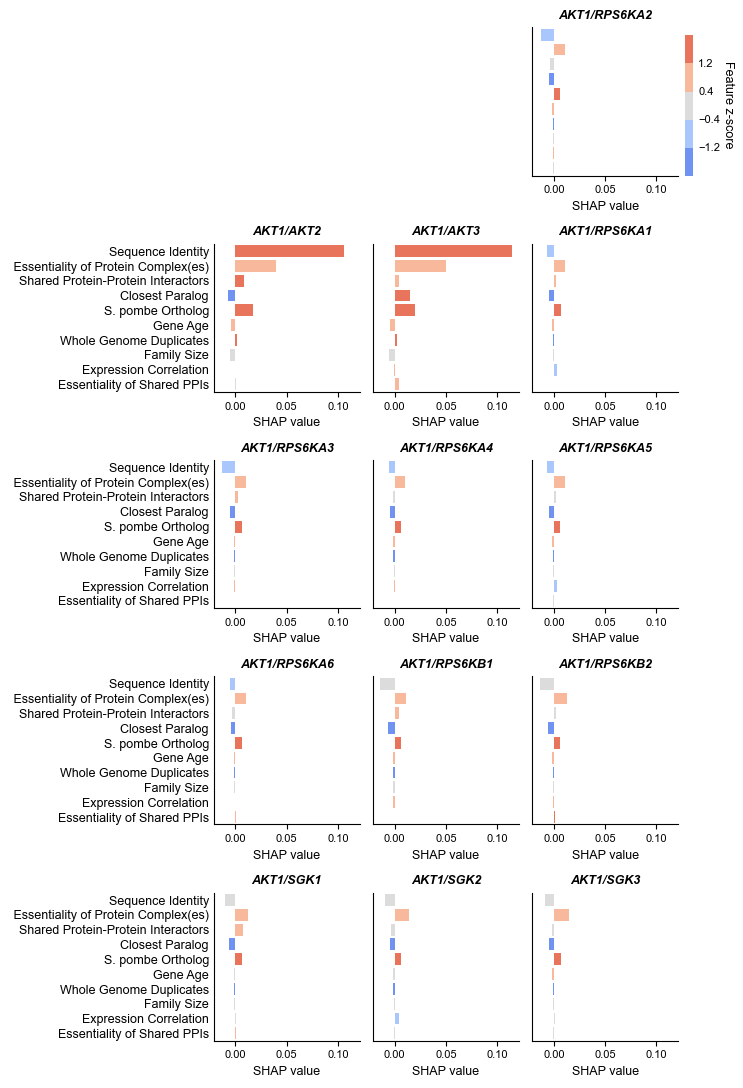

In [52]:
f, axes = plt.subplots(nrows=5, ncols=3, figsize=(6.95, 10.95), sharex=True, sharey=True)
axes = axes.flatten()
for idx, row in all_paralog_annotations[all_paralog_annotations.A1=='AKT1'][['A1','A2']].reset_index(0).iterrows():
    if idx < 3: ax = axes[idx+3]
    elif idx == 3: ax = axes[2]
    else: ax = axes[idx+2]
    draw_shap_plot_for_pair(row.A1, row.A2, ax, feature_order=top_features[:10])
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
axes[0].axis('off'); axes[1].axis('off')
plt.tight_layout()
draw_colorbar(f, axes[2], cmap, zmin, zmax, height=0.95, xpadding=0.01, width=0.012)
f.savefig("../figures/for_paper/shap_plot_AKT1.svg", bbox_inches="tight", dpi=300)

### Unexpected feature values

,sorted_gene_pair,feature,zscore,shap_value,feature_value,A1,A2,prediction_rank,simple_name,global_feat_rank
17193,UBB_UBC,min_sequence_identity,-0.166931,-0.013863,0.333,UBB,UBC,938,Sequence Identity,0


Rank UBB_UBC: 2.56%


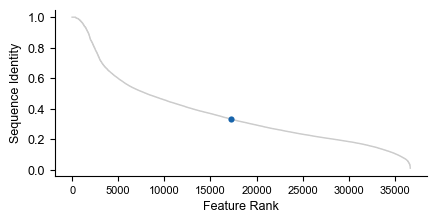

In [54]:
df = all_shap_and_zscore[all_shap_and_zscore.feature=='min_sequence_identity']
df = df.sort_values('feature_value', ascending=False).reset_index(drop=True).astype({'feature_value':'float'})
display(df[df.sorted_gene_pair=='UBB_UBC'])
print('Rank UBB_UBC: %.2f%%' % (df[df.sorted_gene_pair=='UBB_UBC'].prediction_rank.values[0]/all_predictions.shape[0]*100))

f, ax = plt.subplots(1, 1, figsize=(4.8,2.2))
pal = sns.color_palette("Blues", n_colors=9)
sns.lineplot(x=df.index, y=df.feature_value, ax=ax, color='#ccc', zorder=0)
sns.scatterplot(x=df[df.sorted_gene_pair=='UBB_UBC'].index, y=df[df.sorted_gene_pair=='UBB_UBC'].feature_value, ax=ax, 
                linewidth=0, s=20, color=pal[7], zorder=2)
ax.set_ylabel('Sequence Identity'); _ = ax.set_xlabel('Feature Rank')

,sorted_gene_pair,feature,zscore,shap_value,feature_value,A1,A2,prediction_rank,simple_name,global_feat_rank
28450,RAB1A_RAB1B,family_size,0.238646,-0.007703,15.0,RAB1A,RAB1B,219,Family Size,7


Rank RAB1A_RAB1B: 0.60%


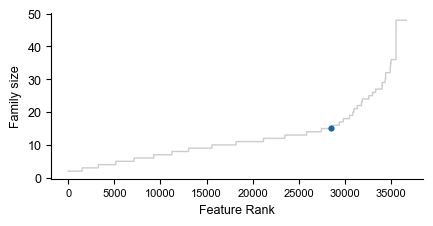

In [56]:
df = all_shap_and_zscore[all_shap_and_zscore.feature=='family_size']
df = df.sort_values('feature_value', ascending=True).reset_index(drop=True).astype({'feature_value':'float'})
display(df[df.sorted_gene_pair=='RAB1A_RAB1B'])
print('Rank RAB1A_RAB1B: %.2f%%' % 
      (df[df.sorted_gene_pair=='RAB1A_RAB1B'].prediction_rank.values[0]/all_predictions.shape[0]*100))

f, ax = plt.subplots(1, 1, figsize=(4.8,2.2))
pal = sns.color_palette("Blues", n_colors=9)
sns.lineplot(x=df.index, y=df.feature_value, ax=ax, color='#ccc', zorder=0)
sns.scatterplot(x=df[df.sorted_gene_pair=='RAB1A_RAB1B'].index, y=df[df.sorted_gene_pair=='RAB1A_RAB1B'].feature_value, ax=ax, 
                linewidth=0, s=20, color=pal[7])
ax.set_ylabel('Family size'); _=ax.set_xlabel('Feature Rank')